In [531]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.inspection import permutation_importance

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

import xgboost as xgb 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import yellowbrick.model_selection as ms

In [509]:
csv_training_files = ['../Datasets/landsat_features_more_bands_train.csv',
                          '../Datasets/terraclimate_features_more_bands_training.csv',
                          '../Datasets/nasa_precip_features_training.csv',
                          '../Datasets/soil_use_data_rounded_training.csv',
                          '../Datasets/nasa_terrain_features_rounded_training.csv',
                          '../Datasets/water_quality_training_dataset.csv']

target_columns = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

drop_features = ['pct_agri', 'pct_water', 'pct_wetlands', 'curvature', 'pct_others', 'elevation', 'pct_natural', 'slope', 'pct_urban']
columns_to_drop_from_features = ["Latitude", "Longitude", "Sample Date"] + drop_features

dataHandler = DataOrganizer(target_columns)
dataHandler.load_training_data(csv_training_files, columns_to_drop_from_features, scale=False)
#dataHandler.get_feature_columns()

In [510]:

Feature_data, Target_data = dataHandler.get_training_dataset()


alkalinity_target = Target_data['Total Alkalinity']
electrical_target = Target_data['Electrical Conductance']
phosphorus_target = Target_data['Dissolved Reactive Phosphorus']

full_dataset = dataHandler.get_full_training_dataset()

groups = full_dataset[["Latitude", "Longitude"]].astype(str).agg('|'.join, axis=1).values 
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


alkalinity_train_idx, alkalinity_test_idx = next(gss.split(Feature_data, alkalinity_target, groups=groups)) 
electrical_train_idx, electrical_test_idx = next(gss.split(Feature_data, electrical_target, groups=groups)) 
phosphorous_train_idx, phosphorous_test_idx = next(gss.split(Feature_data, phosphorus_target, groups=groups))

X_train_alkalinity, X_test_alkalinity = Feature_data.iloc[alkalinity_train_idx], Feature_data.iloc[alkalinity_test_idx]
Y_train_alkalinity, Y_test_alkalinity = alkalinity_target.iloc[alkalinity_train_idx], alkalinity_target.iloc[alkalinity_test_idx]

X_train_electrical, X_test_electrical = Feature_data.iloc[electrical_train_idx], Feature_data.iloc[electrical_test_idx]
Y_train_electrical, Y_test_electrical = electrical_target.iloc[electrical_train_idx], electrical_target.iloc[electrical_test_idx]

X_train_phosphorus, X_test_phosphorus = Feature_data.iloc[phosphorous_train_idx], Feature_data.iloc[phosphorous_test_idx]
Y_train_phosphorus, Y_test_phosphorus = phosphorus_target.iloc[phosphorous_train_idx], phosphorus_target.iloc[phosphorous_test_idx]

X_train_alkalinity.columns



Index(['nir', 'green', 'swir16', 'swir22', 'coastal', 'blue', 'red', 'lwir11',
       'NDMI', 'MNDWI', 'Clorfilia', 'Turbidity', 'NDTI', 'NDVI', 'q', 'ppt',
       'pet', 'soil', 'pdsi', 'tmax', 'tmin', 'Saline_Index', 'Runoff_Ratio',
       'Chemical_Solubility', 'rain_7d_nasa', 'rain_3d_nasa', 'rain_12d_nasa',
       'month_sin'],
      dtype='object')

## XGBoost

In [525]:
model_params = {
    'objective' :'reg:squarederror',
    'booster':'dart',
    'learning_rate' : 0.05, # bom
    'max_depth' : 6, # bom, muda comforme adicionar dados 
    'n_estimators' : 100, # bom, muda conforme adicionar dados
    'subsample' : 0.5,
    'colsample_bytree' : 0.6,
    'min_child_weight' : 30.0, ## fixado assim, bom
    'gamma' : 1.5,  ## fixado assim, bom
    'verbosity' : 1,
    'rate_drop' : 0.25, # bom : 0.25
    'skip_drop' : 0.5, # bom : 0.5
    
    'reg_lambda' : 15.0,                # L2 >= 0
    'reg_alpha' : 9.0,
}

model_alcalinity= xgb.XGBRegressor(**model_params)

model_electrical= xgb.XGBRegressor(**model_params)


model_phosphorus= xgb.XGBRegressor(**model_params)

# parametros treino:


In [526]:

model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity,
            eval_set=[(X_test_alkalinity, Y_test_alkalinity)])

model_electrical.fit(X_train_electrical, Y_train_electrical,
            eval_set=[(X_test_electrical, Y_test_electrical)])

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus,
            eval_set=[(X_test_phosphorus, Y_test_phosphorus)])

[0]	validation_0-rmse:71.99863
[1]	validation_0-rmse:71.00433
[2]	validation_0-rmse:70.14974
[3]	validation_0-rmse:69.26884
[4]	validation_0-rmse:68.64115
[5]	validation_0-rmse:68.17531
[6]	validation_0-rmse:67.40743
[7]	validation_0-rmse:67.06426
[8]	validation_0-rmse:66.39124
[9]	validation_0-rmse:65.90340
[10]	validation_0-rmse:65.31269
[11]	validation_0-rmse:64.90902
[12]	validation_0-rmse:64.42970
[13]	validation_0-rmse:63.97622
[14]	validation_0-rmse:63.44279
[15]	validation_0-rmse:63.05248
[16]	validation_0-rmse:62.66984
[17]	validation_0-rmse:62.50803
[18]	validation_0-rmse:62.43262
[19]	validation_0-rmse:62.35158
[20]	validation_0-rmse:62.09460
[21]	validation_0-rmse:62.05915
[22]	validation_0-rmse:62.02496
[23]	validation_0-rmse:61.97510
[24]	validation_0-rmse:61.91537
[25]	validation_0-rmse:61.56904
[26]	validation_0-rmse:61.52233
[27]	validation_0-rmse:61.49705
[28]	validation_0-rmse:61.20531
[29]	validation_0-rmse:61.15203
[30]	validation_0-rmse:60.94029
[31]	validation_0-

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'dart'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.6
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

## Random Forest

In [380]:
params = {
    'n_estimators':320,           # [100-500] Núm. de árvores. Mais é melhor, mas pesa no PC.
    'max_depth':7,                # [4-10] Profundidade. Mantenha baixo para evitar decorar o mapa.
#    'min_samples_leaf':10,        # [5-50] Mín. de amostras por folha. Ótimo contra overfitting.
    'max_features':0.5,        # ['sqrt', 'log2', 0.5] Quantas colunas cada árvore vê. 
#                                # 'sqrt' força o modelo a não depender só de Tmax/Relevo.
    'bootstrap':True,             # Usa amostras aleatórias dos dados.
    'n_jobs':-1,                  # Usa todos os núcleos do seu processador (muito rápido).
#    'random_state':42,
#    'verbose':0
}

model_alcalinity= RandomForestRegressor(**params)
    
model_electrical= RandomForestRegressor(**params)

model_phosphorus= RandomForestRegressor(**params)


In [381]:
model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity)

model_electrical.fit(X_train_electrical, Y_train_electrical)

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",320
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",7
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",0.5
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

## training

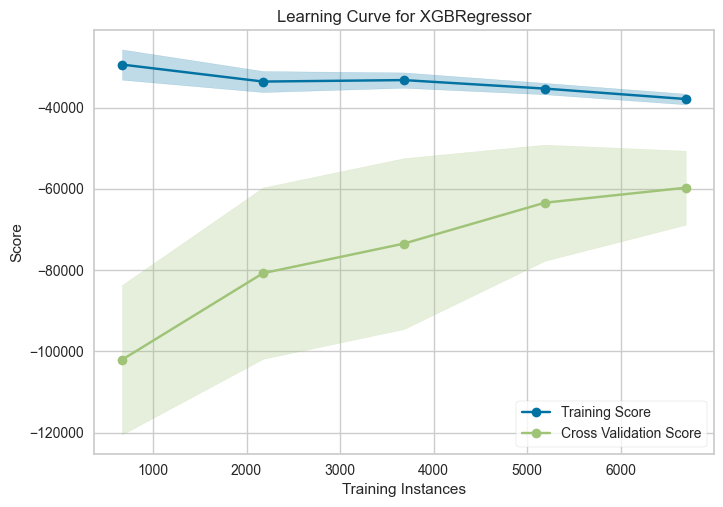

In [463]:
_ = ms.learning_curve(model_electrical, X_train_electrical, Y_train_electrical, scoring='neg_mean_squared_error', cv=5)

<Axes: >

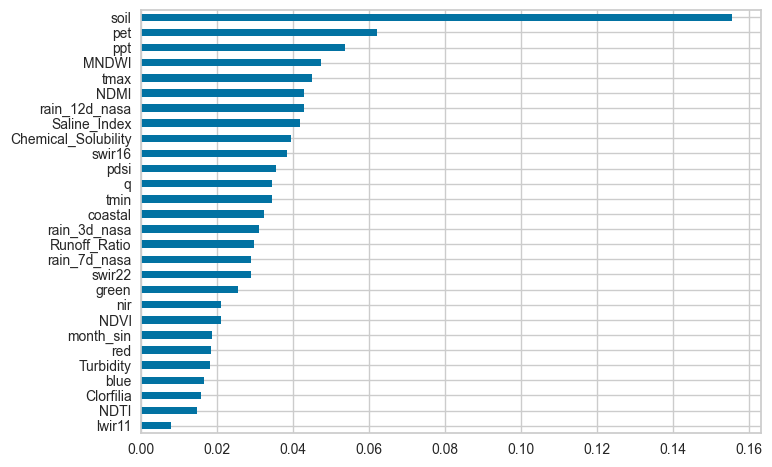

In [527]:
(pd.Series(model_alcalinity.feature_importances_, index = X_train_alkalinity.columns).sort_values().plot.barh())


<Axes: >

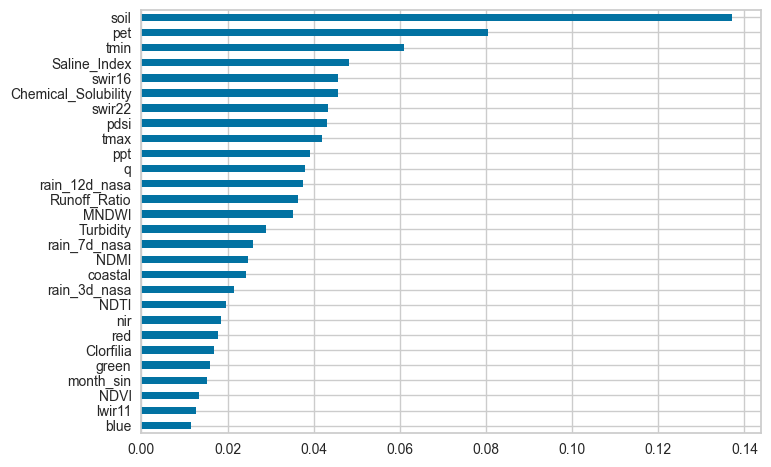

In [528]:

(pd.Series(model_electrical.feature_importances_, index = X_train_electrical.columns).sort_values().plot.barh())


<Axes: >

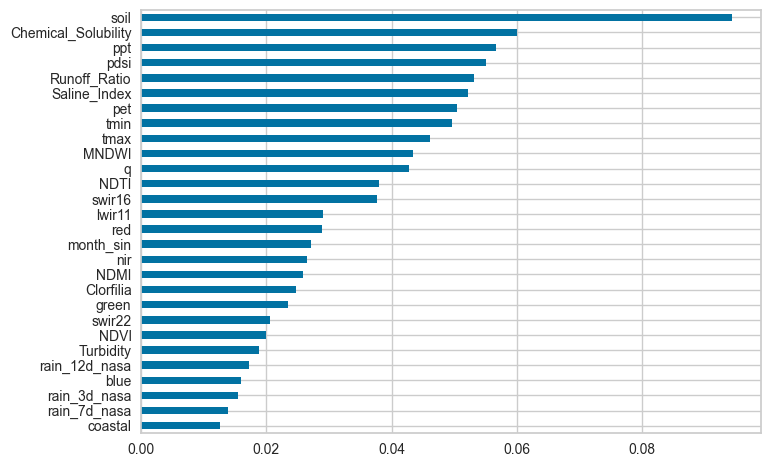

In [529]:

(pd.Series(model_phosphorus.feature_importances_, index = X_train_phosphorus.columns).sort_values().plot.barh())

In [530]:
#make the print in green
print("\033[92mavaliando fosforo\033[0m")
evaluate_model(model_phosphorus.predict(X_train_phosphorus), Y_train_phosphorus, "train evaluation")
evaluate_model(model_phosphorus.predict(X_test_phosphorus), Y_test_phosphorus, "test evaluation")

print()
print("\033[92mavaliando alcalinidade\033[0m")
evaluate_model(model_alcalinity.predict(X_train_alkalinity), Y_train_alkalinity, "train evaluation")
evaluate_model(model_alcalinity.predict(X_test_alkalinity), Y_test_alkalinity, "test evaluation")

print()
print("\033[92mavaliando condutividade eletrica\033[0m")
evaluate_model(model_electrical.predict(X_train_electrical), Y_train_electrical, "train evaluation")
evaluate_model(model_electrical.predict(X_test_electrical), Y_test_electrical, "test evaluation")

avaliando fosforo

train evaluation Evaluation:
R²: 0.487
RMSE: 35.038

test evaluation Evaluation:
R²: 0.039
RMSE: 55.914

avaliando alcalinidade

train evaluation Evaluation:
R²: 0.643
RMSE: 44.952

test evaluation Evaluation:
R²: 0.309
RMSE: 59.070

avaliando condutividade eletrica

train evaluation Evaluation:
R²: 0.661
RMSE: 201.776

test evaluation Evaluation:
R²: 0.244
RMSE: 278.351


(array([192.54077, 188.24074, 166.46178, ..., 529.7445 , 328.62442,
        790.72253], dtype=float32),
 0.24416208257386862,
 np.float64(278.35090722996705))

## Submission

In [491]:
submission_csv_files = ['../Datasets/landsat_features_more_bands_validation.csv',
                          '../Datasets/terraclimate_features_more_bands_validation.csv',
                          '../Datasets/nasa_precip_features_validation.csv',
                          '../Datasets/soil_use_data_validation.csv',
                          '../Datasets/nasa_terrain_features_validation.csv'
]

dataHandler.load_submission_data(submission_csv_files)
all_submission_data = dataHandler.get_submission_dataset()

In [492]:

X_pred_input_features = all_submission_data

y_submission_pred_alkalinity = model_alcalinity.predict(X_pred_input_features)
y_submission_pred_electrical = model_electrical.predict(X_pred_input_features)
y_submission_pred_phosphorus = model_phosphorus.predict(X_pred_input_features)

predicted_values_dict = {
    'Total Alkalinity': y_submission_pred_alkalinity, 
    'Electrical Conductance': y_submission_pred_electrical, 
    'Dissolved Reactive Phosphorus': y_submission_pred_phosphorus
}


predicted_pd_final = dataHandler.build_get_submission_dataset(predicted_values_dict)

predicted_pd_final.to_csv("../Results/submission_predictions_boosted_more_data.csv", index=False)


## Averiguando Importância das Features ( sinal ou lixo )

In [534]:


def get_real_signals(model, X_val, y_val, target_name):
    # Calcula a importância por permutação
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
    
    # Cria um DataFrame com os resultados
    perm_df = pd.DataFrame({
        'feature': X_val.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    
    print(f"--- Sinais Reais para {target_name} ---")
    print(perm_df.head(10))
    return perm_df

#alkalinity

signals_alcalinity = get_real_signals(model_alcalinity, X_test_alkalinity, Y_test_alkalinity, "Alkalinity")
signals_alcalinity


--- Sinais Reais para Alkalinity ---
                feature  importance_mean  importance_std
17                 soil         0.164400        0.012935
16                  pet         0.070540        0.005127
15                  ppt         0.037615        0.003554
9                 MNDWI         0.036486        0.004850
19                 tmax         0.023640        0.002338
26        rain_12d_nasa         0.022719        0.003533
23  Chemical_Solubility         0.018814        0.002802
8                  NDMI         0.016087        0.001890
2                swir16         0.014432        0.001536
18                 pdsi         0.014246        0.002962


,feature,importance_mean,importance_std
17,soil,0.164400,0.012935
16,pet,0.070540,0.005127
15,ppt,0.037615,0.003554
9,MNDWI,0.036486,0.004850
19,tmax,0.023640,0.002338
26,rain_12d_nasa,0.022719,0.003533
23,Chemical_Solubility,0.018814,0.002802
8,NDMI,0.016087,0.001890
2,swir16,0.014432,0.001536
18,pdsi,0.014246,0.002962
